In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import skorch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skorch.helper import SliceDataset
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import warnings
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

num_classes = 4
learning_rate = 0.001
train_size= .70
testsize=.30
train_data=None
test_set=None
#
transform = transforms.Compose(
[transforms.Resize((32,32)),
    transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class AIFaceDetection:
    testsize=.3 
    train_dataset = None
    test_dataset = None
    batchsize =32
    num_epochs = 4
    def __init__(self,dataset_name,model):
        
        #imagenet_data = torchvision.datasets.ImageNet('./new_dataset/')
        dataset = datasets.ImageFolder(('./%s/')%dataset_name,
                                          transform=transform)


        labels = dataset.classes
        classes=dataset.classes
        print(labels)

        dataset_size = len(dataset)
        print(dataset_size)
        print(dataset)
        test_size = int(testsize * dataset_size)
        train_size = dataset_size - test_size
        print('>> TRAINING DATA SIZE : ',train_size)
        #print(train_size)
        print('>> TESTING DATA SIZE : ',test_size )
        #print(test_size)
        train_dataset,test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])
        
        self.test_set=test_dataset
        self.train_data=train_dataset
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batchsize,shuffle = True,num_workers=2)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batchsize,shuffle = True,num_workers=2)
        
        if model == None:
            model = self.train(train_loader)
            print("\n\nTraining is completed and model is saved as dataset_name . pkl \n\n")

            pkl_model =dataset_name + ".pkl"
            torch.save(model.state_dict(), ('./%s')%pkl_model)
        else: 
            
            print("\n\nNOW USING SAVED MODEL <dataset_name>.pkl\n\n")
            model = CNN()
            pkl_model =dataset_name + ".pkl"
            
            model.load_state_dict(torch.load(('./%s')%pkl_model), strict=False)
        print('Evaluating')
        true_class,predicted_class = self.test(model,test_loader)
        self.evaluate(true_class,predicted_class,labels)
    
    def train(self,train_loader):
        model = CNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        total_step = len(train_loader) 
        loss_list = []
        acc_list = []
        
        for epoch in range(self.num_epochs):
          for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) 
            loss_list.append(loss.item())
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() 
            acc_list.append(correct / total)
            if (i + 1) % 100 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, self.num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))
        return model
    
    def evaluate(self,real_class,predicted_class,labels):
   
        torch.manual_seed(0)
        DEVICE = torch.device("cpu")
        y_train = np.array([y for x, y in iter(self.train_data)])
        net = skorch.classifier.NeuralNetClassifier(
              CNN,
              max_epochs=1,
              iterator_train__num_workers=4,
              iterator_valid__num_workers=4,
              lr=1e-3,
              batch_size=64,
              optimizer=torch.optim.Adam,
              criterion=nn.CrossEntropyLoss,
              device=DEVICE)
        
        net.fit(self.train_data, y=y_train)
        y_pred = net.predict(self.test_set)
        y_test = np.array([y for x, y in iter(self.test_set)])
        print (accuracy_score(y_test, y_pred))
        plot_confusion_matrix(net, self.test_set, y_test.reshape(-1, 1))
        print('show confusion maatrix')
        plt.show()
        print(classification_report(real_class, predicted_class, target_names=labels))
        
        return real_class,predicted_class
        
    
    def test(self,model,test_loader):
        model.eval() 
        with torch.no_grad():
            correct = 0
            total = 0
            predicted_class = []
            real_class = []
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                predicted_class += list(predicted.numpy())
                real_class += list(labels.numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print('TEST ACCURACY: {} %'. format((correct / total) * 100))
        return real_class,predicted_class
    
   
    

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 64, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
        )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

['people_wearing_cloth_mask', 'people_wearing_ffp2_mask', 'people_wearing_no_mask', 'people_wearing_surgical_mask']
5119
Dataset ImageFolder
    Number of datapoints: 5119
    Root location: ./mask_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
>> TRAINING DATA SIZE :  3584
>> TESTING DATA SIZE :  1535
Epoch [1/4], Step [100/112], Loss: 0.2057, Accuracy: 93.75%
Epoch [2/4], Step [100/112], Loss: 0.6652, Accuracy: 87.50%
Epoch [3/4], Step [100/112], Loss: 0.1659, Accuracy: 96.88%
Epoch [4/4], Step [100/112], Loss: 0.2943, Accuracy: 90.62%


Training is completed and model is saved as dataset_name . pkl 


Evaluating
TEST ACCURACY: 93.09446254071662 %
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8640  

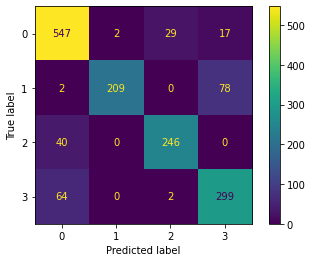

                              precision    recall  f1-score   support

   people_wearing_cloth_mask       0.94      0.90      0.92       595
    people_wearing_ffp2_mask       0.99      0.97      0.98       289
      people_wearing_no_mask       0.92      1.00      0.96       286
people_wearing_surgical_mask       0.88      0.91      0.89       365

                    accuracy                           0.93      1535
                   macro avg       0.93      0.94      0.94      1535
                weighted avg       0.93      0.93      0.93      1535



In [4]:
#THis to train the model, this will take some time to execute.Run once to create the model file
AIFaceDetection('mask_dataset',None)

['people_wearing_cloth_mask', 'people_wearing_ffp2_mask', 'people_wearing_no_mask', 'people_wearing_surgical_mask']
5119
Dataset ImageFolder
    Number of datapoints: 5119
    Root location: ./mask_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
>> TRAINING DATA SIZE :  3584
>> TESTING DATA SIZE :  1535


NOW USING SAVED MODEL <dataset_name>.pkl


Evaluating
TEST ACCURACY: 94.46254071661238 %
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0389       0.8173        0.5148  56.1790
0.8338762214983714
show confusion maatrix


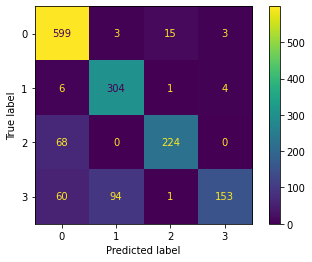

                              precision    recall  f1-score   support

   people_wearing_cloth_mask       0.96      0.92      0.94       620
    people_wearing_ffp2_mask       1.00      0.98      0.99       315
      people_wearing_no_mask       0.94      1.00      0.97       292
people_wearing_surgical_mask       0.88      0.91      0.89       308

                    accuracy                           0.94      1535
                   macro avg       0.94      0.95      0.95      1535
                weighted avg       0.95      0.94      0.94      1535



In [5]:
#THis to use the saved model, this wont train the model but use the saved model
AIFaceDetection('mask_dataset','Y') # Second param can be anything as long as it is not None.

In [ ]:
# We can test a single image using the below. Place the photo to be tested in test Folder

In [6]:
transform = transforms.Compose(
[transforms.Resize((32,32)),
    transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 



test_dataset = datasets.ImageFolder('./testing_dataset/', transform=transform)
#test_dataset = datasets.ImageFolder('./testing_dataset/')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle = True)

def test_a_image(model):
        model.eval() 
        actual_lab=None;
        predicted_lab=None;
        
        with torch.no_grad():
            for images, labels in test_loader:
                
                #print(images.name)
                
                plt.figure(figsize=(16,8))
                #plt.figure()
                plt.axis('off')
                plt.imshow( make_grid(images,nrow=1).permute((1, 2, 0)))
                #plt.imshow(np.uint8(make_grid(images,nrow=1)))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                print("Actual label:" ,test_dataset.classes[labels.numpy()[0]])
                actual_lab=test_dataset.classes[labels.numpy()[0]]
                print("Prediction: ",test_dataset.classes[predicted[0]])
                predicted_lab=test_dataset.classes[predicted[0]]
                
                break
                
        if actual_lab != predicted_lab:
            print ('WRONG PREDCITION')
        else:
            print ('CORRECT PREDICTION ! BRAVO')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: people_wearing_cloth_mask
Prediction:  people_wearing_cloth_mask
CORRECT PREDICTION ! BRAVO


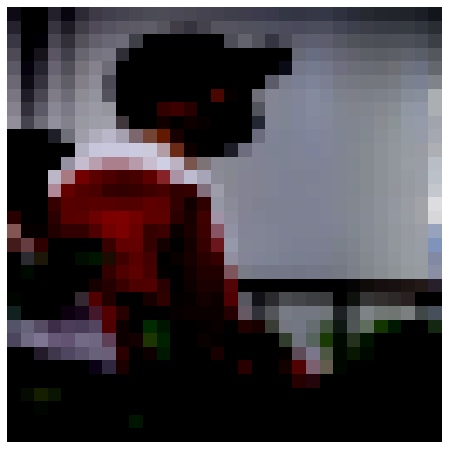

In [8]:
model = CNN()
model.load_state_dict(torch.load("./new_dataset.pkl" ), strict=False)
test_a_image(model)